In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pickle
import string
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# # Авторизация гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/

In [4]:
# создаем датасет для проверки функций
np.random.seed(42)
n = 600
assert_data = pd.DataFrame(columns=['id', 'member_id', 'issue_d', 'target', 'test_flg', 'atr_int_1', 'atr_int_2', 'atr_int_3', 'atr_cat_1', 'atr_cat_2', 'atr_cat_3'])
assert_data['id'] = range(n)
assert_data['member_id'] = range(n)
assert_data['issue_d'] = [datetime.datetime.strftime(datetime.date(2000,1,1) + relativedelta(months=d),'%Y-%m-%d') for d in range(60)] * int(n/60)
assert_data['target'] = [np.random.randint(2) for i in range(n)]
assert_data['test_flg'] = [np.random.randint(2) for i in range(n)]
for i in range(1, 4):
    assert_data[f'atr_int_{i}'] = np.random.random(n)
    assert_data.loc[np.random.randint(0, n, 20), f'atr_int_{i}'] = np.nan
    assert_data[f'atr_cat_{i}'] = np.random.random_integers(0, 25, n)
    assert_data.loc[np.random.randint(0, n, 20), f'atr_cat_{i}'] = np.nan


assert_tech_columns = ['id', 'member_id', 'issue_d', 'target']
assert_interrval_features = [f'atr_int_{i}' for i in range(1, 4)]
assert_category_features = [f'atr_cat_{i}' for i in range(1, 4)]
assert_features = assert_interrval_features + assert_category_features

assert_data.head()

,id,member_id,issue_d,target,test_flg,atr_int_1,atr_int_2,atr_int_3,atr_cat_1,atr_cat_2,atr_cat_3
0,0,0,2000-01-01,0,0,0.168935,0.603219,0.000135,19.0,13.0,21.0
1,1,1,2000-02-01,1,1,0.278590,0.337227,0.511129,1.0,8.0,21.0
2,2,2,2000-03-01,0,1,0.177010,0.905525,0.046852,14.0,22.0,0.0
3,3,3,2000-04-01,0,1,0.088703,0.772623,0.276170,13.0,24.0,16.0
4,4,4,2000-05-01,0,0,0.120636,0.264895,0.706976,19.0,18.0,10.0


# Загрузка датасета

Описание полей датасета в файле: LCDataDictionary.xlsx (надо отредактировать файл, возможно там есть лишние столбцы)

In [5]:
data_backup = pd.read_csv('./dataset_2_out.csv')
print(data_backup.shape)
data_backup.head(2)

(311521, 32)


,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,mths_since_last_major_derog,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,target,test_flg
0,5000,0,10.65,6,1,5,24000.0,2,2011-12-01,1,...,5000.00,861.07,0.0,171.62,NaN,0.0,NaN,NaN,0,0
1,2500,1,15.27,13,10,5,30000.0,1,2011-12-01,0,...,456.46,435.17,0.0,119.66,NaN,0.0,NaN,NaN,1,0


In [6]:
data = data_backup.copy()

Сформируем списки технических, категориальных и интервальных атрибутов

In [7]:
# Список технических полей
tech_columns = ['id', 'member_id', 'issue_d', 'target', 'test_flg']
print(f"Количество технических атрибутов: {len(tech_columns)}")

# Список категориальных атрибутов
with open('./category_features.pickle', 'rb') as f:
    category_features = pickle.load(f)
print(f"Количество категориальных атрибутов: {len(category_features)}")

# Список интервальных атрибутов
interrval_features = list(set(data.columns) - set(tech_columns) - set(category_features))
print(f"Количество интервальных атрибутов: {len(interrval_features)}")

# Список всех атрибутов: категориальные + интервальные
features = interrval_features + category_features
print(f"Общее количество атрибутов: {len(features)}")

Количество технических атрибутов: 5
Количество категориальных атрибутов: 8
Количество интервальных атрибутов: 21
Общее количество атрибутов: 29


# Task 1. Биннинг атрибутов.

## Task 1-a
> Реализуйте функцию, которая бинаризует каждый интервальный атрибут.

> При реализации функции учтите следующее:
* Для реализации бининга воспользуйтесь pandas.qcut
* В словарь не добавляйте первую и последнюю границы, полученные функцией pandas.qcut
* Бининг производится только на заполненных наблюдениях

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. interval_attributes - список интервальных атрибутов
3. category_attributes - список категориальных атрибутов
4. num_bins - количество бинов, на которые надо разбить значения атрибутов
* Возвращает словарь, ключами которого являются названия атрибутов, а значениями список из границ бинов

In [8]:
def calc_binning(data_, interval_attributes, num_bins):
    res = {}
    for atr in interval_attributes:
#         print(atr, data_[atr].notna().sum())
        cut, bins = pd.qcut(data_[atr][data_[atr].notna()], num_bins, retbins=True, duplicates='drop')
        bins = np.round(bins, 5)
        bins = bins[1:-1]
        res[atr] = bins
    return res
    

In [67]:
assert_binning_dict

{'atr_int_1': array([0.08593, 0.17834, 0.26782, 0.38497, 0.50246, 0.59108, 0.70886,
        0.81154, 0.89288]),
 'atr_int_2': array([0.10569, 0.17048, 0.27644, 0.37903, 0.5203 , 0.61498, 0.69162,
        0.7917 , 0.87927]),
 'atr_int_3': array([0.07212, 0.17522, 0.26209, 0.35703, 0.467  , 0.58009, 0.67408,
        0.76757, 0.89139])}

In [9]:
# Проверяем реализацию функции
assert_binning_dict = calc_binning(data_=assert_data[assert_data['test_flg']==0].copy(),
                                   interval_attributes=assert_interrval_features,
                                   num_bins=10
                                   )

assert len(assert_binning_dict.keys()) == 3
res = 0
res_1 = 0
res__1 = 0
for col in assert_binning_dict.keys():
    res += assert_binning_dict[col].sum()
    res_1 += assert_binning_dict[col][0]
    res__1 += assert_binning_dict[col][-1]
assert round(res, 5) ==  13.09998
assert round(res_1, 5) == 0.26374
assert round(res__1, 5) == 2.66354

In [10]:
assert_binning_dict

{'atr_int_1': array([0.08593, 0.17834, 0.26782, 0.38497, 0.50246, 0.59108, 0.70886,
        0.81154, 0.89288]),
 'atr_int_2': array([0.10569, 0.17048, 0.27644, 0.37903, 0.5203 , 0.61498, 0.69162,
        0.7917 , 0.87927]),
 'atr_int_3': array([0.07212, 0.17522, 0.26209, 0.35703, 0.467  , 0.58009, 0.67408,
        0.76757, 0.89139])}

In [11]:
%%time
# Применяем функцию к целевой таблице
binning_dict = calc_binning(data_=data[data['test_flg']==0].copy(),
                            interval_attributes=interrval_features,
                            num_bins=10
                            )

Wall time: 286 ms


## Task 1-b
> Реализуйте функцию, которая по каждому значению атрибута проставляет каждому наблюдению номер группы в зависимости от значения атрибута.

> При реализации функции учтите следующее:
* Для интервальных атрибутов:
1. Бины состоят из полуинтервалов вида: '(board_X, board_Y]'
1. Если не удалось разбинить атрибут (все наблюдения попадают в один бин), то всем наблюдениям присваивается номер группы: '(-inf, +inf)'
2. Если наблюдение принадлежит первому или последнему бину, то номер группы должен выглядеть следующим образом: '(-inf, board_1]' и '(board_N, +inf)', соответственно
3. Все случаи пропсуков должны быть выделены в отдельный бин с названием 'MISSING'
* Для категориальных атрибутов: будем использовать самый простой вариант биннинга - каждое значение категориального атрибута является своим номером группы 

Имена столбцов с номерами групп должны иметь имена формата: 'GRP_col', где col - имя атрибута
Приведите номера групп в строковый формат (str).

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. interval_attributes - список интервальных атрибутов
3. category_attributes - список категориальных атрибутов
4. dict_binning - словарь бининга, полученный из предыдущей функции
* Возвращает pandas.DataFrame с идентичными полями, что и исходный датафрейм + дополняет его именами групп ('GRP_col') для каждого атрибута

In [12]:
def make_grps(data_, interval_attributes, category_attributes, dict_binning):
    for col in interval_attributes:
        bins = [-np.inf] + dict_binning[col].tolist() + [+np.inf]
        data_['GRP_'+str(col)] = pd.cut(data_[col], bins).astype(str)        
        data_['GRP_'+str(col)] = data_['GRP_'+str(col)].str.replace('inf]', '+inf)')
        data_['GRP_'+str(col)] = data_['GRP_'+str(col)].str.replace('nan', 'MISSING')

    for col in category_attributes:
        data_['GRP_'+str(col)] = data_[col].astype(str).str.replace('nan', 'MISSING')
        
    return data_

In [74]:
assert_data_binned[assert_data_binned.columns[assert_data_binned.columns.str.startswith('atr')]].sum()

atr_int_1     287.193880
atr_int_2     285.088473
atr_int_3     289.834000
atr_cat_1    7289.000000
atr_cat_2    7142.000000
atr_cat_3    7643.000000
dtype: float64

In [13]:
# Проверяем реализацию функции
assert_data_binned = make_grps(data_= assert_data.copy(), 
                               interval_attributes = assert_interrval_features, 
                               category_attributes = assert_category_features, 
                               dict_binning = assert_binning_dict
                               )

assert assert_data_binned.shape == (600, 17)
re1 = r"^\(\-inf, \+inf\)$"
re2 = "^\([-+]?[0-9]*[.]?[0-9]+, \+inf\)$"
re3 = "^\(\-inf, [-+]?[0-9]*[.]?[0-9]+\]$"
re4 = "^\([-+]?[0-9]*[.]?[0-9]+, [-+]?[0-9]*[.]?[0-9]+\]$"
re5 = "^MISSING$"
generic_re = re.compile("(%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5))
flg_assert = True
for i in range(1, 4):
    col = f'GRP_atr_int_{i}'
    flg_assert = flg_assert * (np.sum(assert_data_binned[col].str.fullmatch(generic_re)) == assert_data_binned.shape[0])
assert flg_assert

res_int = 0
res_cat = 0
for i in range(1, 4):
    col = f'GRP_atr_int_{i}'
    res_int += np.hstack(assert_data_binned[col].apply(lambda x: np.array(re.findall('[-+]?[0-9]*[.]?[0-9]+', x), dtype=float))).sum()
    col = f'GRP_atr_cat_{i}'
    res_cat += np.hstack(assert_data_binned[col].apply(lambda x: np.array(re.findall('[-+]?[0-9]*[.]?[0-9]+', x), dtype=float))).sum()

assert round(res_int, 5) == 1530.3575 #1530.37743
assert round(res_cat, 5) == 22074.0

In [14]:
%%time
# Применяем функцию к целевой таблице
data_binned = make_grps(data_=data.copy(), 
                        interval_attributes=interrval_features, 
                        category_attributes=category_features, 
                        dict_binning=binning_dict
                        )

Wall time: 29 s


#Task 2. Вычисление значение WOE-факторов

## Task 2-a
> Реализуйте функцию, которая вычисляет значение WOE-фактора для каждого бина каждого атрибута.

> Если атрибут разбит на n категорий, то для категории i WOE рассчитывается по следующей формуле:
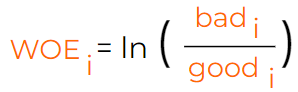
* bad_i - доля всех плохих клиентов (целевое событие 1), которая попадает в группу i
* good_i - доля всех плохих клиентов (целевое событие 0), которая попадает в группу i

> При реализации функции учтите следующее:
* При необходимости, чтобы избежать NAN в качестве значения WOE, замените все пропуски при вычислении на 0.00001.

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. attributes_ - список атрибутов
3. target_name - имя колонки с целевым событием
* Возвращает словарь, ключами которого являются названия атрибутов, а значениями pandas.DataFrame со столбцами: GRP_col и WOE_col, где col - имя атрибута



In [65]:
def calc_woe(data_, attributes_, target_name):
    eps = 0.00001
    res_dict = {}
    for col in attributes_:
        df = data_[['GRP_'+str(col), target_name]]
        val_counts = df.groupby(target_name)['GRP_'+col].value_counts()
        
        bad = val_counts[1]/df[target_name].value_counts()[1]
        good = val_counts[0]/df[target_name].value_counts()[0]
        bad_good = pd.concat([good.rename('good'), bad.rename('bad')], axis=1).fillna(eps)
        
        res_df = np.log(bad_good['bad']/bad_good['good'])
        
        res_df = res_df.fillna(eps)
        res_df = res_df.to_frame('WOE_'+col).reset_index()
        res_dict[str(col)] = res_df

    return res_dict

In [79]:
for k in assert_woe_dict.keys():
    print(assert_woe_dict[k]['WOE_'+k].sum())

0.49205259761878595
-0.24811595668802067
0.6458843490427671
1.6657355901535835
7.786949334413125
0.13608809811067035


In [66]:
# Проверяем реализацию функции
assert_woe_dict = calc_woe(data_= assert_data_binned[assert_data_binned['test_flg']==0], attributes_ = assert_features, target_name='target')

assert len(assert_woe_dict.keys()) == 6
res = 0
for col in assert_woe_dict.keys():
    res += np.array(assert_woe_dict[col].shape)
assert set(res) == {12, 114}

In [17]:
%%time
# Применяем функцию к целевой таблице
woe_dict = calc_woe(data_=data_binned[data_binned['test_flg']==0], attributes_=features, target_name='target')

Wall time: 4.29 s


## Task 2-b
> Реализуйте функцию, которая каждому наблюдению присоединяет значение WOE в зависимости от значения атрибута.

> При реализации функции учтите следующее:
* При необходимости, чтобы избежать NAN в столбцах со значениями WOE, замените все пропуски на 0.

Имена столбцов со значением WOE должны иметь имена формата: 'WOE_col', где col - имя атрибута

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. attributes_ - список атрибутов
3. dict_woe - словарь со значениями WOE из предыдущей функции
* Возвращает pandas.DataFrame с идентичными полями, что и исходный датафрейм + дополняет его значениями WOE ('WOE_col') для каждого атрибута

In [18]:
def merge_woe(data_, attributes_, dict_woe):
    for col in attributes_:
        woes = dict_woe[col]
        data_ = data_.merge(woes, on='GRP_'+str(col) )
    return data_

In [19]:
# Проверяем реализацию функции
assert_data_binned_woe = merge_woe(data_ = assert_data_binned.copy(), attributes_ = assert_features, dict_woe = assert_woe_dict)

assert assert_data_binned_woe.shape == (600, 23)

woe_sum = -np.array([6.41035, 10.09985, -8.87265, -47.36889, -114.97994, 7.88363])
for i, col in enumerate(['int_1', 'int_2', 'int_3', 'cat_1', 'cat_2', 'cat_3']):
    assert round(assert_data_binned_woe[f'WOE_atr_{col}'].sum(), 5) == woe_sum[i]

In [20]:
%%time
# Применяем функцию к целевой таблице
data_binned_woe = merge_woe(data_=data_binned.copy(), attributes_=features, dict_woe=woe_dict)

Wall time: 38.2 s


# Task 3. Однофакторный анализ

> Реализуйте функцию формирования однофакторного анализа, для каждого атрибута вычисляет следующие характеристики данного атрибута:
* Коэффициент Джини на train выборке
* Коэффициент Джини на test выборке
* Значение PSI 

> При реализации функции учтите следующее:
* Коэффициент Джини можно вычислить, как 2*roc_auc_score-1
* PSI вычисляется по формуле: 
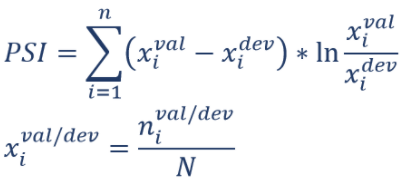
* n_i - количество наблюдений в группе i на выборке для разработки (dev) или тестирования (val)
* N - число наблюдений в выборке для разработки или тестировании (dev или val)

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. attributes_ - список атрибутов
3. target_name - имя целевого события
4. test_flg_name - имя столбца с флагом тестовой выборки
* Возвращает pandas.DataFrame со следующими полями:
1. Attribute - имя атрибута
2. GINI test - коэффициент Джини на test выборке
3. GINI train - коэффициент Джини на Train выборке
4. GINI delta - относительное изменение коэффициента Джини на test по сравнению с train
5. PSI - значение PSI для атрибута


In [61]:
def one_factor_analyses_function(data_, attributes_, target_name, test_flg_name):
    gini_train =[]
    gini_test = []
    psi = []
    train = data_[data_[test_flg_name] == 0]
    test = data_[data_[test_flg_name] == 1]
    
    for col in attributes_:                    
        x_dev = train['GRP_'+col].value_counts()/len(train)
        x_val = test['GRP_'+col].value_counts()/len(test)
        psi.append( ((x_val-x_dev) * np.log(x_val/x_dev)).sum() )
        
        gini_train.append(abs(2*roc_auc_score(train[target_name], train['WOE_'+col]) - 1))
        gini_test.append(abs(2*roc_auc_score(test[target_name], test['WOE_'+col]) - 1))
        
    gini_train = np.array(gini_train)
    gini_test = np.array(gini_test)
    
    res_df = pd.DataFrame({'Attribute': attributes_,  
                           'GINI test': gini_test, 
                           'GINI train': gini_train, 
                           'GINI delta': (gini_test-gini_train)/gini_train,
                           'PSI' : psi})
    return res_df


In [63]:
# Проверяем реализацию функции
assert_one_factor_analyses = one_factor_analyses_function(data_ = assert_data_binned_woe.copy(), 
                                                   attributes_ = assert_features, 
                                                   target_name = 'target', 
                                                   test_flg_name = 'test_flg'
                                                   )


assert assert_one_factor_analyses.shape == (6, 5)
assert set(assert_one_factor_analyses.columns) == {'Attribute', 'GINI test', 'GINI train', 'GINI delta', 'PSI'}
print(round(assert_one_factor_analyses['GINI train'].sum(), 5) )
print(round(assert_one_factor_analyses['GINI test'].sum(), 5) )
print(round(assert_one_factor_analyses['GINI delta'].sum(), 5))
print(round(assert_one_factor_analyses['PSI'].sum(), 5) )

assert round(assert_one_factor_analyses['GINI train'].sum(), 5) == 1.6009 #1.6008
assert round(assert_one_factor_analyses['GINI test'].sum(), 5) == 0.29121 #0.286
assert round(assert_one_factor_analyses['GINI delta'].sum(), 5) == -4.70174 #-4.7197
assert round(assert_one_factor_analyses['PSI'].sum(), 5) == 0.91081 # 0.9109

1.6009
0.29121
-4.70174
0.91081


In [64]:
%%time
# Применяем функцию к целевой таблице
one_factor_analyses = one_factor_analyses_function(data_=data_binned_woe.copy(), 
                                                   attributes_=features, 
                                                   target_name='target', 
                                                   test_flg_name='test_flg'
                                                   )

Wall time: 9.05 s


Выведем результаты однофакторного анализа, отсортированные по убыванию коэффициента Джини на train выборке

In [24]:
one_factor_analyses.sort_values('GINI train', ascending=False)

,Attribute,GINI test,GINI train,GINI delta,PSI
2,total_rec_prncp,0.628066,0.688035,-0.087160,0.217053
17,last_pymnt_amnt,0.278599,0.487544,-0.428566,0.158302
26,sub_grade,0.328978,0.302459,0.087678,0.042070
8,int_rate,0.332826,0.296296,0.123288,0.068219
14,out_prncp,0.476369,0.176990,1.691509,0.885630
5,annual_inc,0.142836,0.138037,0.034766,0.012758
21,term,0.098812,0.120807,-0.182067,0.020514
9,dti,0.110815,0.110785,0.000268,0.025451
6,revol_util,0.074620,0.106181,-0.297233,0.017059
22,purpose,0.067974,0.093312,-0.271539,0.088900


# Task 4. Многофакторный анализ

Сформируем длинный список "хороших" атрибутов:
* Отбираем атрибуты, удовлетворяющие условиям на величину коэффициентов, вычисленных на этапе однофакторного анализа
* Сортируем список атрибутов по уменьшению GINI на train выборке

In [25]:
good_features_long = list(one_factor_analyses[(one_factor_analyses['GINI train'] > 0.05)
                                               & (abs(one_factor_analyses['GINI delta']) < 0.50)
                                               & (one_factor_analyses['PSI'] < 0.20)
                                             ].sort_values('GINI train', ascending=False)['Attribute'])

print(f'Number of good features: {len(good_features_long)}')

Number of good features: 15


Также для отбора атрибутов можно использовать встренные в sklearn методы, которые основаны на статистическом отборе признаков по их влиянию на целевую переменную

In [26]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2, f_classif , mutual_info_classif 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train = data_binned_woe[data_binned_woe['test_flg']==0]
X_test  = data_binned_woe[data_binned_woe['test_flg']==1]
X_train[interrval_features] = X_train[interrval_features].fillna(X_train[interrval_features].mean())
X_test[interrval_features] = X_test[interrval_features].fillna(X_train[interrval_features].mean())

scaler = MinMaxScaler()
X_train.loc[:, interrval_features] = scaler.fit_transform(X_train[interrval_features])
X_test.loc[:, interrval_features]  = scaler.transform(X_test[interrval_features])

In [27]:
selector = SelectKBest(k=10, score_func=chi2)
selector.fit(X_train[interrval_features], X_train['target'])

# Список отобранных атрибутов
selector.get_feature_names_out()

array(['total_rec_prncp', 'annual_inc', 'revol_util', 'int_rate', 'dti',
       'inq_last_6mths', 'total_rec_int', 'out_prncp', 'last_pymnt_amnt',
       'tot_cur_bal'], dtype=object)

In [28]:
estimator = LogisticRegression()
recursive_selector = RFE(estimator, n_features_to_select=10)
recursive_selector.fit(X_train[interrval_features], X_train['target'])

# Список отобранных атрибутов
recursive_selector.get_feature_names_out()

array(['revol_bal', 'total_rec_prncp', 'open_acc', 'annual_inc',
       'revol_util', 'inq_last_6mths', 'total_rec_late_fee', 'out_prncp',
       'last_pymnt_amnt', 'loan_amnt'], dtype=object)

Построим и отобразим матрицу корреляций Спирмена для длинного списка "хороших" атрибутов

In [29]:
corr_matrix = data_binned_woe[data_binned_woe['test_flg']==0][['WOE_'+col for col in good_features_long]].corr(method='spearman')
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,WOE_last_pymnt_amnt,WOE_sub_grade,WOE_int_rate,WOE_annual_inc,WOE_term,WOE_dti,WOE_revol_util,WOE_purpose,WOE_total_rec_int,WOE_tot_cur_bal,WOE_total_rev_hi_lim,WOE_home_ownership,WOE_verification_status,WOE_inq_last_6mths,WOE_addr_state
WOE_last_pymnt_amnt,1.00,-0.02,-0.02,0.21,-0.05,0.03,0.02,0.01,0.06,0.08,0.11,0.09,-0.10,-0.03,0.03
WOE_sub_grade,-0.02,1.00,0.99,0.02,0.44,0.15,0.40,0.14,-0.25,0.08,0.12,0.11,0.22,0.18,0.02
WOE_int_rate,-0.02,0.99,1.00,0.03,0.42,0.16,0.41,0.14,-0.25,0.07,0.10,0.11,0.22,0.18,0.02
WOE_annual_inc,0.21,0.02,0.03,1.00,-0.15,0.19,-0.04,0.02,0.16,0.31,0.28,0.28,-0.16,-0.07,0.03
WOE_term,-0.05,0.44,0.42,-0.15,1.00,0.07,0.05,0.05,-0.21,-0.09,-0.10,-0.13,0.38,0.04,-0.01
WOE_dti,0.03,0.15,0.16,0.19,0.07,1.00,0.21,0.03,-0.09,0.00,-0.16,-0.00,0.19,0.01,-0.04
WOE_revol_util,0.02,0.40,0.41,-0.04,0.05,0.21,1.00,-0.00,-0.17,-0.02,0.09,0.03,0.09,-0.07,-0.02
WOE_purpose,0.01,0.14,0.14,0.02,0.05,0.03,-0.00,1.00,-0.00,0.03,0.06,0.04,0.05,0.02,0.01
WOE_total_rec_int,0.06,-0.25,-0.25,0.16,-0.21,-0.09,-0.17,-0.00,1.00,0.05,0.12,0.04,-0.17,-0.01,0.01
WOE_tot_cur_bal,0.08,0.08,0.07,0.31,-0.09,0.00,-0.02,0.03,0.05,1.00,0.31,0.49,-0.16,-0.06,0.04


> Реализуйте функцию отбора короткого списка "хороших" атрибутов на основе корреляции атрибутов.

> Алгоритм отбора признаков следующий:
* Все признаки сортируются по уменьшению коэффициента Джини на train выборке
* Затем они поочередно добавляются в новый список, если не коррелируют с другими атрибутами из этого списка
* Атрибуты считаются скоррелированными, если коэффициент корреляции >= 50%

> Описание функции:
* На вход принимает:
1. features_list - длинный список атрибутов
2. corr - матрицу корреляций для длинного списка атрибутов
* Возвращает короткий список "хороших" атрибутов

In [30]:
def filter_uncorrelated_features(features_list, corr):
    print(features_list)
    res_features = [features_list[0]]
    for candidate in features_list[1:]:
        for cur_feature in res_features:
            if corr['WOE_'+cur_feature]['WOE_'+candidate] >=0.5:
                break
        else:
            res_features.append(candidate)
    return res_features

In [31]:
# Проверяем реализацию функции
assert_corr_matrix = assert_data_binned_woe[assert_data_binned_woe['test_flg']==0][['WOE_'+col for col in assert_features]].corr()
assert_good_features_short = filter_uncorrelated_features(features_list = assert_features, corr = assert_corr_matrix)
print(f'Количество хороших некоррелирующих атрибутов: {len(assert_good_features_short)}')

assert len(assert_good_features_short) == 6
temp_corr = assert_corr_matrix.reset_index()
temp_corr = temp_corr[temp_corr['index'].isin(['WOE_'+col for col in assert_features])][['index']+['WOE_'+col for col in assert_features]].set_index('index')
assert np.sum(temp_corr.values<0.1) == 18
assert round(np.sum(temp_corr.values), 5) == 7.50577

['atr_int_1', 'atr_int_2', 'atr_int_3', 'atr_cat_1', 'atr_cat_2', 'atr_cat_3']
Количество хороших некоррелирующих атрибутов: 6


In [32]:
# Применяем функцию к целевой таблице
good_features_short = filter_uncorrelated_features(features_list=good_features_long, corr=corr_matrix)
print(f'Количество хороших некоррелирующих атрибутов: {len(good_features_short)}')

['last_pymnt_amnt', 'sub_grade', 'int_rate', 'annual_inc', 'term', 'dti', 'revol_util', 'purpose', 'total_rec_int', 'tot_cur_bal', 'total_rev_hi_lim', 'home_ownership', 'verification_status', 'inq_last_6mths', 'addr_state']
Количество хороших некоррелирующих атрибутов: 14


Отобразим однофакторный анализ короткого "хорошего" списка атрибутов

In [33]:
one_factor_analyses[one_factor_analyses['Attribute'].isin(good_features_short)].sort_values('GINI train', ascending=False)

,Attribute,GINI test,GINI train,GINI delta,PSI
17,last_pymnt_amnt,0.278599,0.487544,-0.428566,0.158302
26,sub_grade,0.328978,0.302459,0.087678,0.042070
5,annual_inc,0.142836,0.138037,0.034766,0.012758
21,term,0.098812,0.120807,-0.182067,0.020514
9,dti,0.110815,0.110785,0.000268,0.025451
6,revol_util,0.074620,0.106181,-0.297233,0.017059
22,purpose,0.067974,0.093312,-0.271539,0.088900
12,total_rec_int,0.081824,0.088307,-0.073412,0.037264
19,tot_cur_bal,0.109140,0.080191,0.360996,0.119292
16,total_rev_hi_lim,0.109091,0.079117,0.378853,0.114348


Построим и отобразим матрицу корреляций Пирсона для короткого списка "хороших" атрибутов, из результатов видно, что корреляция не превышает порог в 50%

In [34]:
temp_corr = corr_matrix.reset_index()
temp_corr = temp_corr[temp_corr['index'].isin(['WOE_'+col for col in good_features_short])][['index']+['WOE_'+col for col in good_features_short]].set_index('index')
temp_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,WOE_last_pymnt_amnt,WOE_sub_grade,WOE_annual_inc,WOE_term,WOE_dti,WOE_revol_util,WOE_purpose,WOE_total_rec_int,WOE_tot_cur_bal,WOE_total_rev_hi_lim,WOE_home_ownership,WOE_verification_status,WOE_inq_last_6mths,WOE_addr_state
index,,,,,,,,,,,,,,
WOE_last_pymnt_amnt,1.00,-0.02,0.21,-0.05,0.03,0.02,0.01,0.06,0.08,0.11,0.09,-0.10,-0.03,0.03
WOE_sub_grade,-0.02,1.00,0.02,0.44,0.15,0.40,0.14,-0.25,0.08,0.12,0.11,0.22,0.18,0.02
WOE_annual_inc,0.21,0.02,1.00,-0.15,0.19,-0.04,0.02,0.16,0.31,0.28,0.28,-0.16,-0.07,0.03
WOE_term,-0.05,0.44,-0.15,1.00,0.07,0.05,0.05,-0.21,-0.09,-0.10,-0.13,0.38,0.04,-0.01
WOE_dti,0.03,0.15,0.19,0.07,1.00,0.21,0.03,-0.09,0.00,-0.16,-0.00,0.19,0.01,-0.04
WOE_revol_util,0.02,0.40,-0.04,0.05,0.21,1.00,-0.00,-0.17,-0.02,0.09,0.03,0.09,-0.07,-0.02
WOE_purpose,0.01,0.14,0.02,0.05,0.03,-0.00,1.00,-0.00,0.03,0.06,0.04,0.05,0.02,0.01
WOE_total_rec_int,0.06,-0.25,0.16,-0.21,-0.09,-0.17,-0.00,1.00,0.05,0.12,0.04,-0.17,-0.01,0.01
WOE_tot_cur_bal,0.08,0.08,0.31,-0.09,0.00,-0.02,0.03,0.05,1.00,0.31,0.49,-0.16,-0.06,0.04


Отобразим биннинг атрибутов из хорошего короткого списка атрибутов (good_features_short)

In [35]:
# Печатаем Биннинг
def print_binning(data, interval_attributes, category_attributes, target, test_flg_name, figsize=(16,8), h_pt=16):
    
    for i, col in enumerate(interval_attributes+category_attributes):
        
#         clear_output(wait=True)
        print(f'Column {i+1}/{len(interval_attributes+category_attributes)}')
        print(col)
        
        
        temp = data.groupby([test_flg_name, col]).agg({target : ['count', 'sum']}).reset_index().sort_values(col)
        temp.columns = [test_flg_name, col, 'cnt', 'def_cnt']
        temp['def_rate'] = temp['def_cnt'] / temp['cnt']
        temp = temp.merge(data.groupby(test_flg_name).agg({target : 'count'}).reset_index(), on=[test_flg_name], how='left')
        temp['pop_rate'] = temp['cnt'] / temp[target]
        temp = temp.drop(columns=[target])
        
        if col in interval_attributes:
            temp['sort_col'] = temp[col].apply(lambda x: np.inf if 'MISSING' in x else float(x[1:-1].split(',')[0]) if x[1:-1].split(',')[0] != '-inf' else -np.inf)
        elif col in category_attributes:
            temp['sort_col'] = temp[col].apply(lambda x: np.inf if 'MISSING' in x else float(x))
        temp = temp.sort_values([test_flg_name, 'sort_col'])
        temp = temp.drop(columns=['sort_col'])
        temp_tr = temp[temp[test_flg_name]==0]
        temp_ts = temp[temp[test_flg_name]==1]
    
        fig, ax1 = plt.subplots(figsize=figsize)
        color = 'tab:blue'
        h_pt = h_pt
        col_name = col.replace('GRP_','')
        ax1.set_title('Распределение доли популяции и уровня дефолта по группам фактора\n'+col_name, fontsize=h_pt)
        ax1.set_xlabel('Группы фактора ' + col_name, fontsize=h_pt)
        ax1.set_ylabel('Доля популяции', fontsize=h_pt)

        plt.bar(temp_tr[col], temp_tr['pop_rate'], align='edge', width=-0.4, edgecolor='black', color=color, label='train')
        plt.bar(temp_ts[col], temp_ts['pop_rate'], align='edge', width=0.4, edgecolor='black', color='lightblue', label='test')
        plt.legend(loc='upper left')

        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Уровень дефолта', fontsize=h_pt)

        plt.plot(temp_tr[col], temp_tr['def_rate'], '+-r', linewidth=5, markersize=20, label='train') 
        plt.plot(temp_ts[col], temp_ts['def_rate'], '+-g', linewidth=5, markersize=20, label='test') 
        plt.legend(loc='upper right')

        ax2.tick_params('y')
        fig.tight_layout()

        plt.show()


        # Печатаем расчетную таблицу
        with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
            print(temp)

Column 1/14
GRP_last_pymnt_amnt


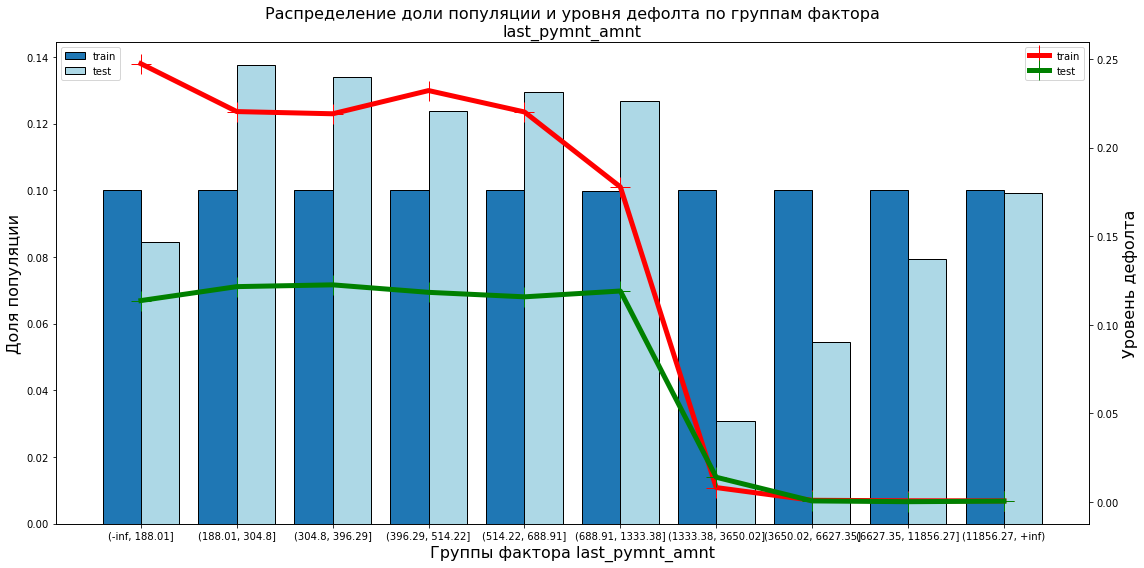

    test_flg  GRP_last_pymnt_amnt    cnt  def_cnt   def_rate  pop_rate
0          0       (-inf, 188.01]  14633     3619  2.473e-01     0.100
6          0      (188.01, 304.8]  14634     3224  2.203e-01     0.100
8          0      (304.8, 396.29]  14630     3205  2.191e-01     0.100
12         0     (396.29, 514.22]  14632     3397  2.322e-01     0.100
15         0     (514.22, 688.91]  14653     3225  2.201e-01     0.100
18         0    (688.91, 1333.38]  14611     2598  1.778e-01     0.100
4          0   (1333.38, 3650.02]  14632      120  8.201e-03     0.100
10         0   (3650.02, 6627.35]  14632       15  1.025e-03     0.100
17         0  (6627.35, 11856.27]  14632       11  7.518e-04     0.100
2          0     (11856.27, +inf)  14632       10  6.834e-04     0.100
1          1       (-inf, 188.01]  13950     1586  1.137e-01     0.084
7          1      (188.01, 304.8]  22746     2765  1.216e-01     0.138
9          1      (304.8, 396.29]  22136     2713  1.226e-01     0.134
13    

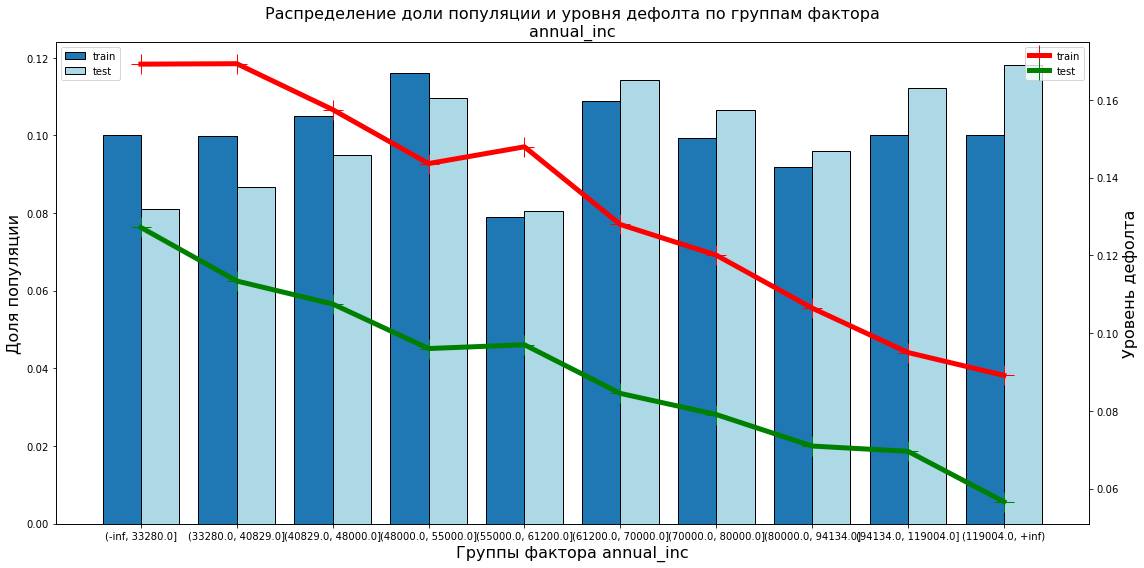

    test_flg       GRP_annual_inc    cnt  def_cnt  def_rate  pop_rate
0          0      (-inf, 33280.0]  14661     2480     0.169     0.100
4          0   (33280.0, 40829.0]  14604     2472     0.169     0.100
6          0   (40829.0, 48000.0]  15356     2418     0.157     0.105
8          0   (48000.0, 55000.0]  16979     2438     0.144     0.116
10         0   (55000.0, 61200.0]  11562     1710     0.148     0.079
12         0   (61200.0, 70000.0]  15924     2037     0.128     0.109
15         0   (70000.0, 80000.0]  14545     1746     0.120     0.099
17         0   (80000.0, 94134.0]  13426     1429     0.106     0.092
18         0  (94134.0, 119004.0]  14632     1390     0.095     0.100
2          0     (119004.0, +inf)  14632     1304     0.089     0.100
1          1      (-inf, 33280.0]  13377     1701     0.127     0.081
5          1   (33280.0, 40829.0]  14322     1624     0.113     0.087
7          1   (40829.0, 48000.0]  15668     1684     0.107     0.095
9          1   (4800

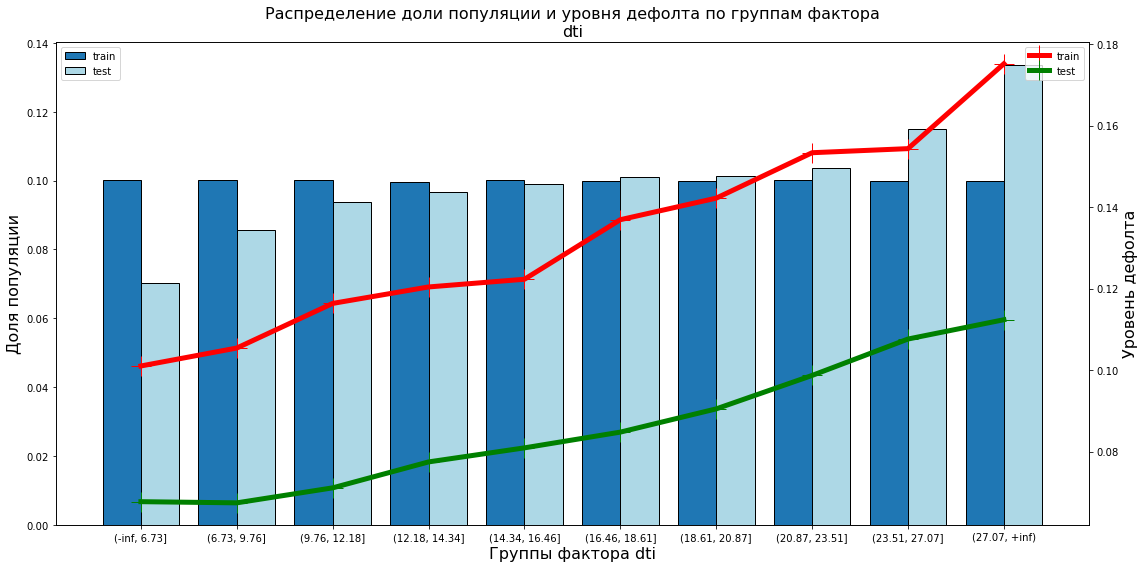

    test_flg         GRP_dti    cnt  def_cnt  def_rate  pop_rate
0          0    (-inf, 6.73]  14641     1479     0.101     0.100
17         0    (6.73, 9.76]  14665     1546     0.105     0.100
18         0   (9.76, 12.18]  14651     1705     0.116     0.100
2          0  (12.18, 14.34]  14583     1756     0.120     0.100
4          0  (14.34, 16.46]  14660     1793     0.122     0.100
6          0  (16.46, 18.61]  14614     2001     0.137     0.100
8          0  (18.61, 20.87]  14612     2078     0.142     0.100
10         0  (20.87, 23.51]  14645     2246     0.153     0.100
12         0  (23.51, 27.07]  14621     2257     0.154     0.100
15         0   (27.07, +inf)  14629     2563     0.175     0.100
1          1    (-inf, 6.73]  11594      785     0.068     0.070
16         1    (6.73, 9.76]  14165      955     0.067     0.086
19         1   (9.76, 12.18]  15471     1100     0.071     0.094
3          1  (12.18, 14.34]  15968     1237     0.077     0.097
5          1  (14.34, 16.

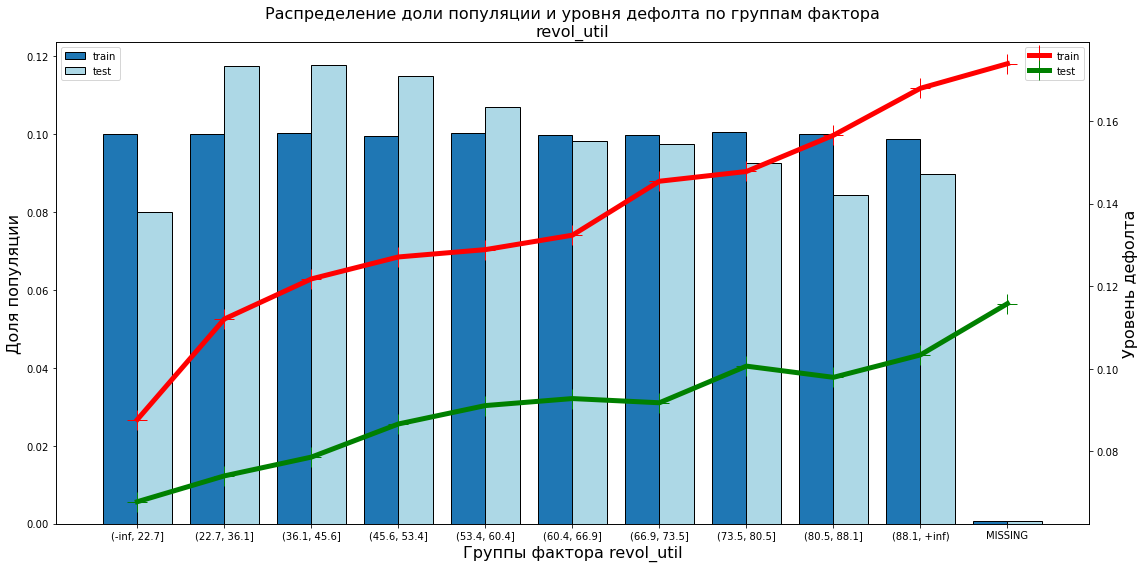

    test_flg GRP_revol_util    cnt  def_cnt  def_rate   pop_rate
0          0   (-inf, 22.7]  14650     1285     0.088  1.001e-01
2          0   (22.7, 36.1]  14652     1642     0.112  1.001e-01
4          0   (36.1, 45.6]  14666     1786     0.122  1.002e-01
6          0   (45.6, 53.4]  14548     1849     0.127  9.943e-02
8          0   (53.4, 60.4]  14681     1892     0.129  1.003e-01
10         0   (60.4, 66.9]  14618     1935     0.132  9.990e-02
12         0   (66.9, 73.5]  14597     2123     0.145  9.976e-02
14         0   (73.5, 80.5]  14716     2175     0.148  1.006e-01
17         0   (80.5, 88.1]  14645     2293     0.157  1.001e-01
19         0   (88.1, +inf)  14456     2428     0.168  9.880e-02
20         0        MISSING     92       16     0.174  6.288e-04
1          1   (-inf, 22.7]  13214      896     0.068  7.999e-02
3          1   (22.7, 36.1]  19390     1436     0.074  1.174e-01
5          1   (36.1, 45.6]  19463     1530     0.079  1.178e-01
7          1   (45.6, 53.

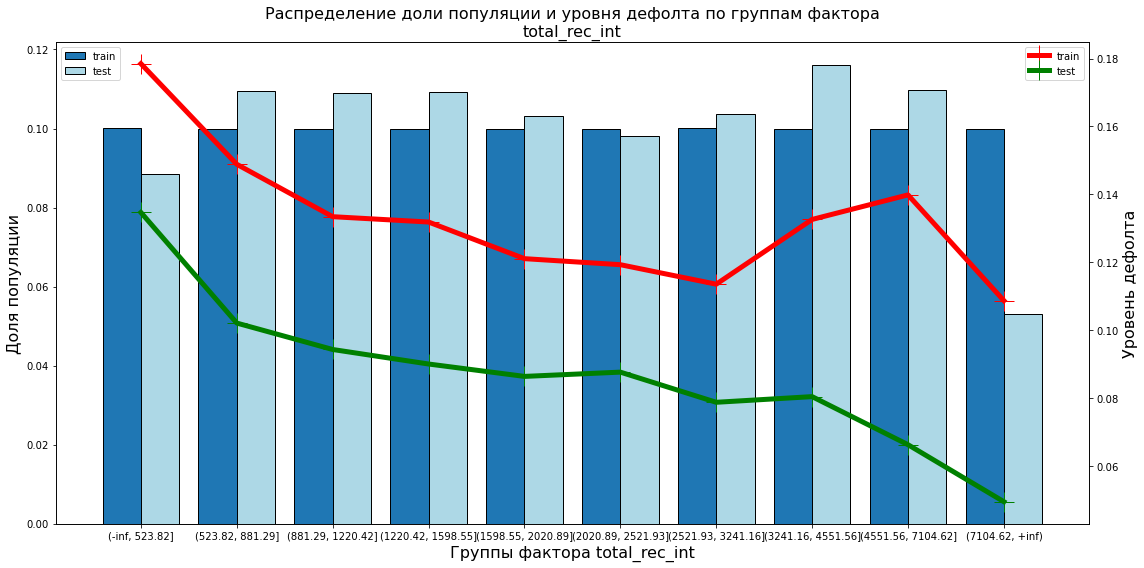

    test_flg   GRP_total_rec_int    cnt  def_cnt  def_rate  pop_rate
0          0      (-inf, 523.82]  14633     2612     0.179     0.100
15         0    (523.82, 881.29]  14632     2178     0.149     0.100
18         0   (881.29, 1220.42]  14632     1952     0.133     0.100
2          0  (1220.42, 1598.55]  14632     1929     0.132     0.100
4          0  (1598.55, 2020.89]  14632     1771     0.121     0.100
6          0  (2020.89, 2521.93]  14632     1745     0.119     0.100
8          0  (2521.93, 3241.16]  14633     1661     0.114     0.100
10         0  (3241.16, 4551.56]  14631     1940     0.133     0.100
12         0  (4551.56, 7104.62]  14632     2046     0.140     0.100
17         0     (7104.62, +inf)  14632     1590     0.109     0.100
1          1      (-inf, 523.82]  14600     1966     0.135     0.088
14         1    (523.82, 881.29]  18099     1847     0.102     0.110
19         1   (881.29, 1220.42]  18003     1697     0.094     0.109
3          1  (1220.42, 1598.55]  

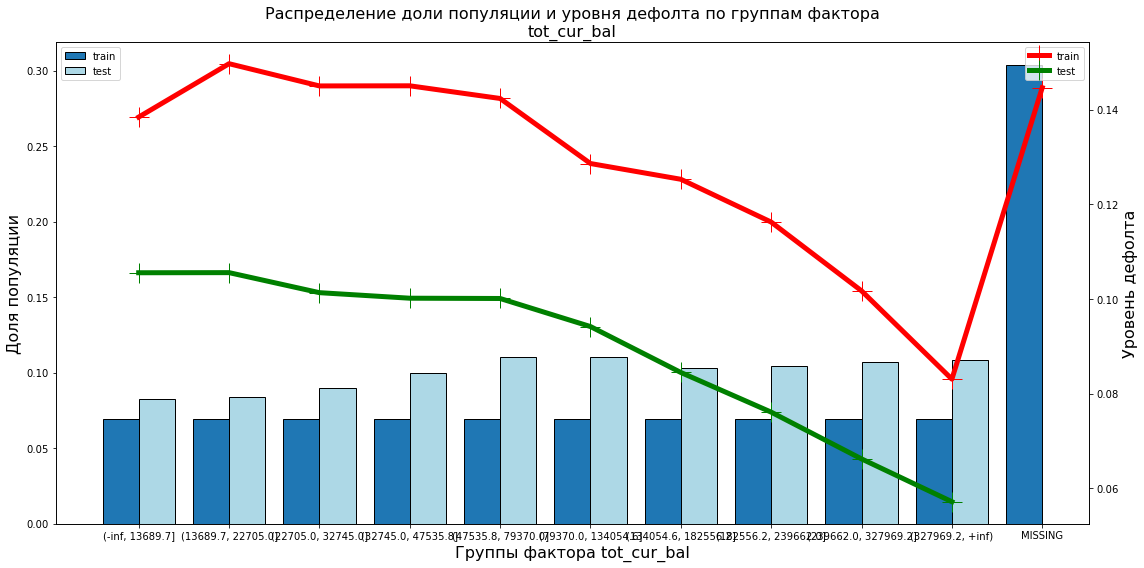

    test_flg       GRP_tot_cur_bal    cnt  def_cnt  def_rate  pop_rate
0          0       (-inf, 13689.7]  10185     1410     0.138     0.070
4          0    (13689.7, 22705.0]  10186     1525     0.150     0.070
8          0    (22705.0, 32745.0]  10185     1477     0.145     0.070
13         0    (32745.0, 47535.8]  10183     1477     0.145     0.070
17         0    (47535.8, 79370.0]  10185     1450     0.142     0.070
19         0   (79370.0, 134054.6]  10185     1310     0.129     0.070
2          0  (134054.6, 182556.2]  10184     1276     0.125     0.070
6          0  (182556.2, 239662.0]  10185     1184     0.116     0.070
10         0  (239662.0, 327969.2]  10185     1036     0.102     0.070
15         0      (327969.2, +inf)  10185      846     0.083     0.070
20         0               MISSING  44473     6433     0.145     0.304
1          1       (-inf, 13689.7]  13672     1443     0.106     0.083
5          1    (13689.7, 22705.0]  13811     1458     0.106     0.084
9     

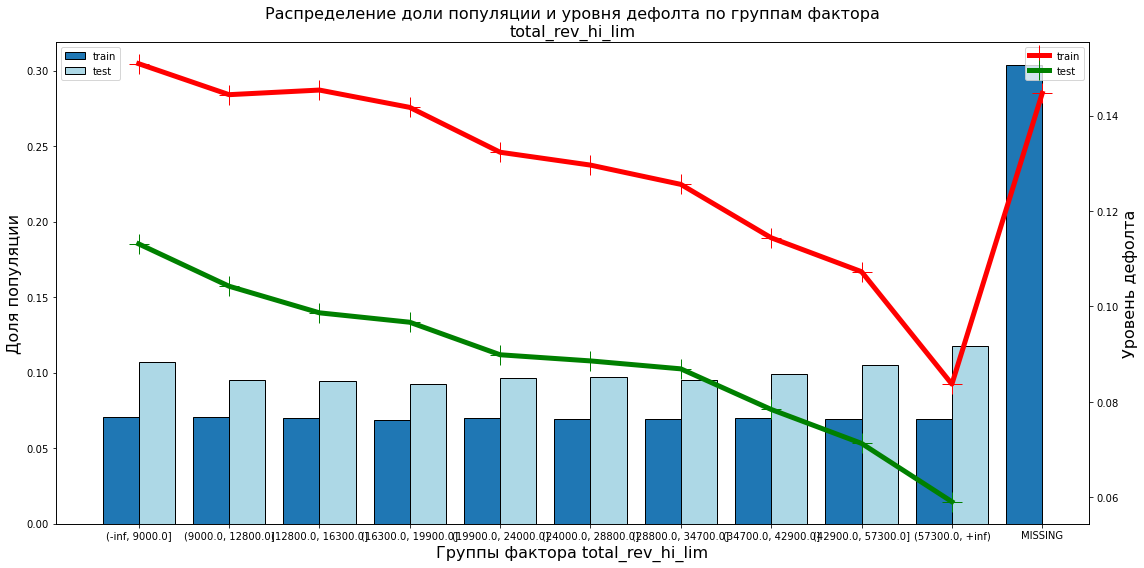

    test_flg GRP_total_rev_hi_lim    cnt  def_cnt  def_rate  pop_rate
0          0       (-inf, 9000.0]  10314     1556     0.151     0.070
19         0    (9000.0, 12800.0]  10293     1486     0.144     0.070
2          0   (12800.0, 16300.0]  10197     1482     0.145     0.070
4          0   (16300.0, 19900.0]  10056     1425     0.142     0.069
6          0   (19900.0, 24000.0]  10219     1352     0.132     0.070
8          0   (24000.0, 28800.0]  10092     1308     0.130     0.069
10         0   (28800.0, 34700.0]  10154     1275     0.126     0.069
13         0   (34700.0, 42900.0]  10221     1169     0.114     0.070
15         0   (42900.0, 57300.0]  10134     1087     0.107     0.069
17         0      (57300.0, +inf)  10168      851     0.084     0.069
20         0              MISSING  44473     6433     0.145     0.304
1          1       (-inf, 9000.0]  17721     2004     0.113     0.107
18         1    (9000.0, 12800.0]  15669     1633     0.104     0.095
3          1   (1280

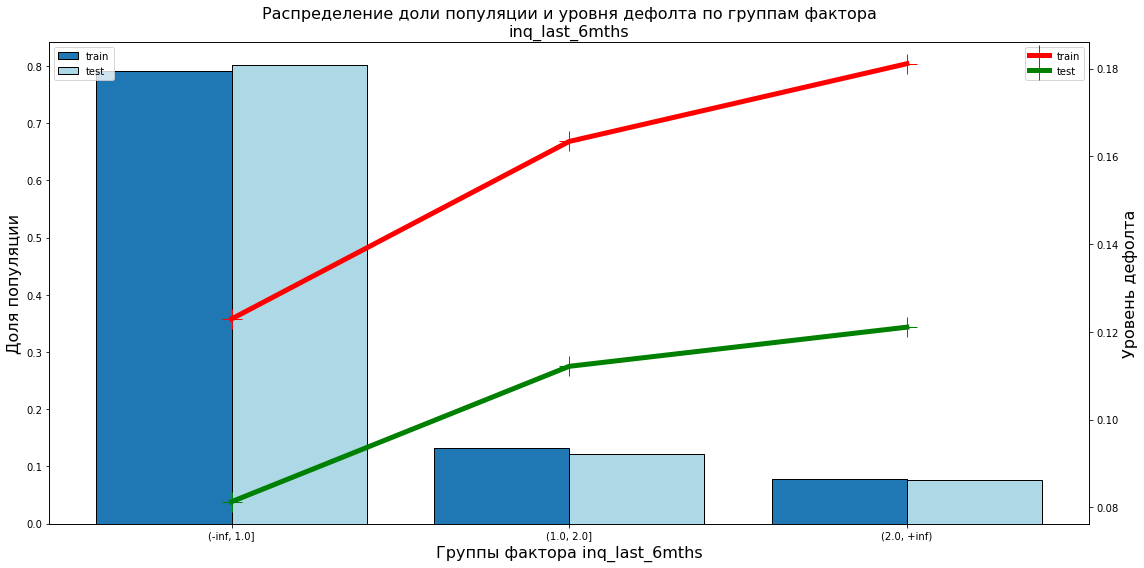

   test_flg GRP_inq_last_6mths     cnt  def_cnt  def_rate  pop_rate
0         0        (-inf, 1.0]  115766    14231     0.123     0.791
2         0         (1.0, 2.0]   19236     3143     0.163     0.131
4         0        (2.0, +inf)   11319     2050     0.181     0.077
1         1        (-inf, 1.0]  132511    10770     0.081     0.802
3         1         (1.0, 2.0]   20154     2260     0.112     0.122
5         1        (2.0, +inf)   12531     1517     0.121     0.076
Column 9/14
GRP_sub_grade


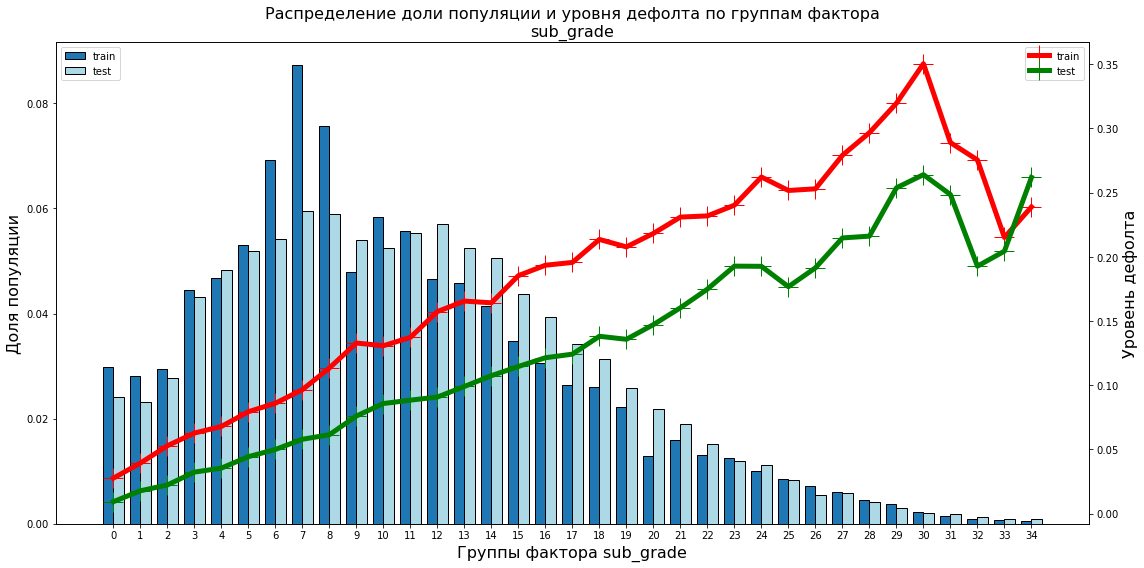

    test_flg GRP_sub_grade    cnt  def_cnt  def_rate   pop_rate
0          0             0   4375      121     0.028  2.990e-02
2          0             1   4115      162     0.039  2.812e-02
24         0             2   4313      228     0.053  2.948e-02
47         0             3   6501      408     0.063  4.443e-02
58         0             4   6835      464     0.068  4.671e-02
61         0             5   7761      616     0.079  5.304e-02
63         0             6  10128      871     0.086  6.922e-02
65         0             7  12784     1234     0.097  8.737e-02
67         0             8  11086     1257     0.113  7.576e-02
68         0             9   7016      932     0.133  4.795e-02
4          0            10   8536     1116     0.131  5.834e-02
6          0            11   8139     1117     0.137  5.562e-02
9          0            12   6820     1073     0.157  4.661e-02
10         0            13   6701     1109     0.165  4.580e-02
13         0            14   6068      9

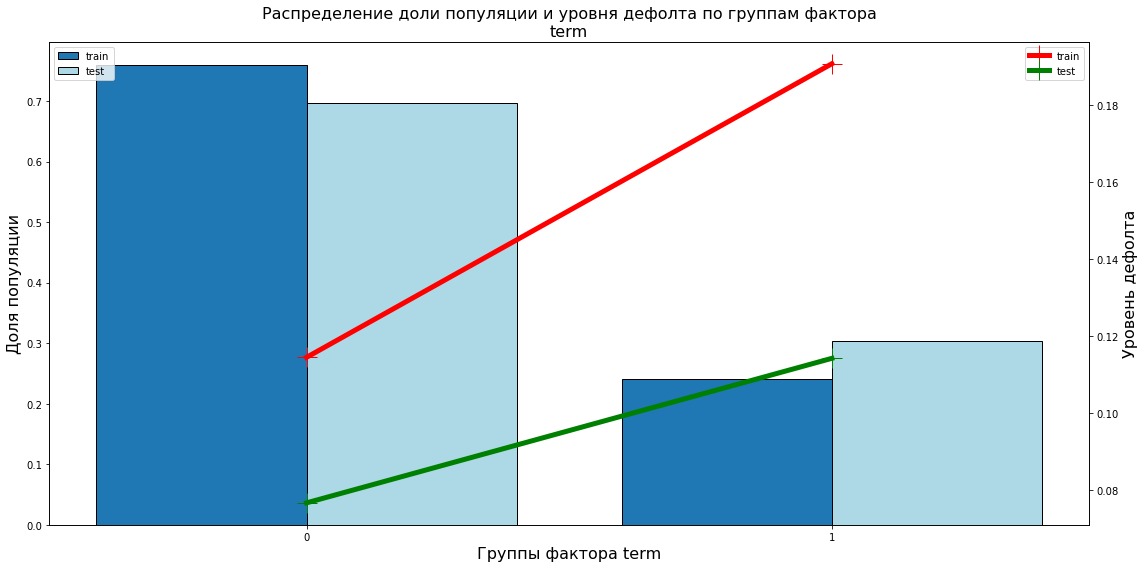

   test_flg GRP_term     cnt  def_cnt  def_rate  pop_rate
0         0        0  111180    12724     0.114     0.760
2         0        1   35141     6700     0.191     0.240
1         1        0  115012     8817     0.077     0.696
3         1        1   50184     5730     0.114     0.304
Column 11/14
GRP_purpose


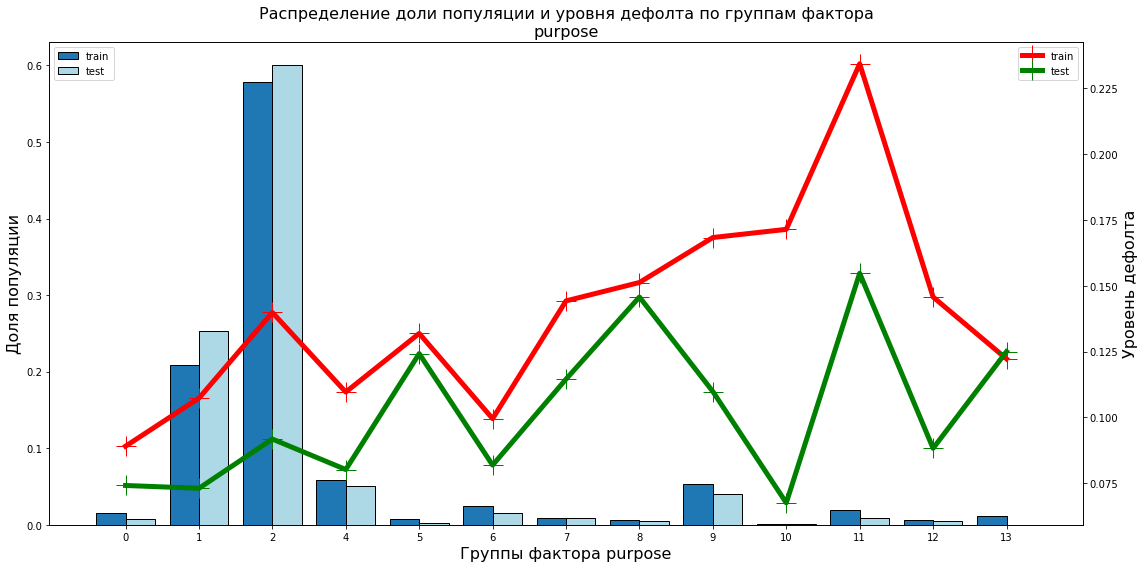

    test_flg GRP_purpose    cnt  def_cnt  def_rate   pop_rate
0          0           0   2324      207     0.089  1.588e-02
2          0           1  30586     3283     0.107  2.090e-01
13         0           2  84706    11847     0.140  5.789e-01
14         0           4   8537      936     0.110  5.834e-02
17         0           5   1016      134     0.132  6.944e-03
19         0           6   3627      361     0.100  2.479e-02
21         0           7   1324      191     0.144  9.049e-03
23         0           8   1005      152     0.151  6.868e-03
24         0           9   7747     1304     0.168  5.295e-02
4          0          10    140       24     0.171  9.568e-04
6          0          11   2821      661     0.234  1.928e-02
8          0          12    844      123     0.146  5.768e-03
10         0          13   1644      201     0.122  1.124e-02
1          1           0   1254       93     0.074  7.591e-03
3          1           1  41769     3053     0.073  2.528e-01
12      

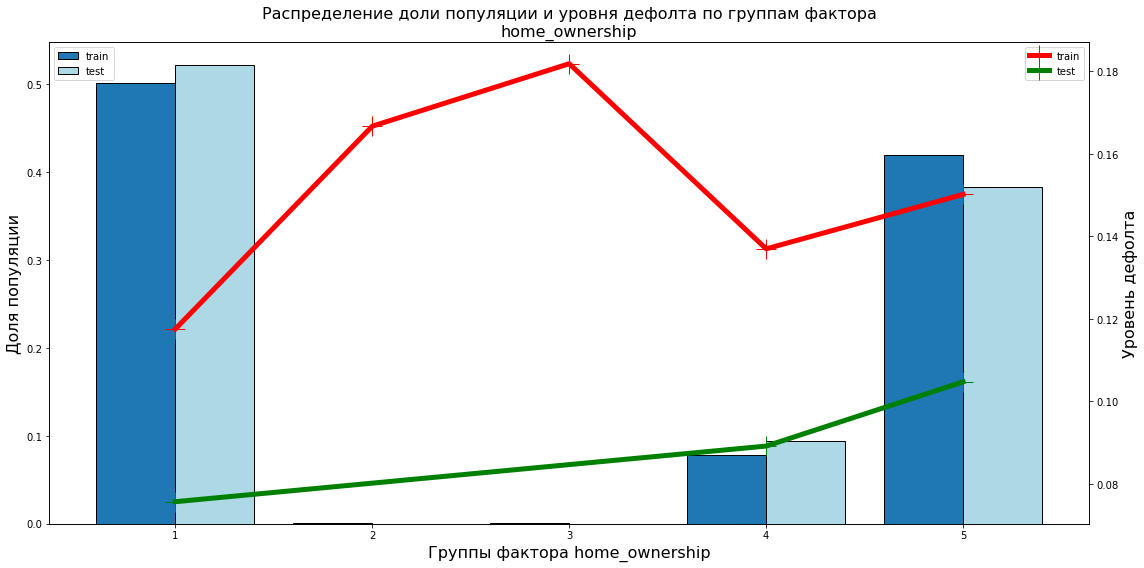

   test_flg GRP_home_ownership    cnt  def_cnt  def_rate   pop_rate
0         0                  1  73343     8617     0.117  5.012e-01
2         0                  2     42        7     0.167  2.870e-04
3         0                  3     44        8     0.182  3.007e-04
4         0                  4  11465     1570     0.137  7.836e-02
6         0                  5  61427     9222     0.150  4.198e-01
1         1                  1  86285     6527     0.076  5.223e-01
5         1                  4  15539     1385     0.089  9.406e-02
7         1                  5  63372     6635     0.105  3.836e-01
Column 13/14
GRP_verification_status


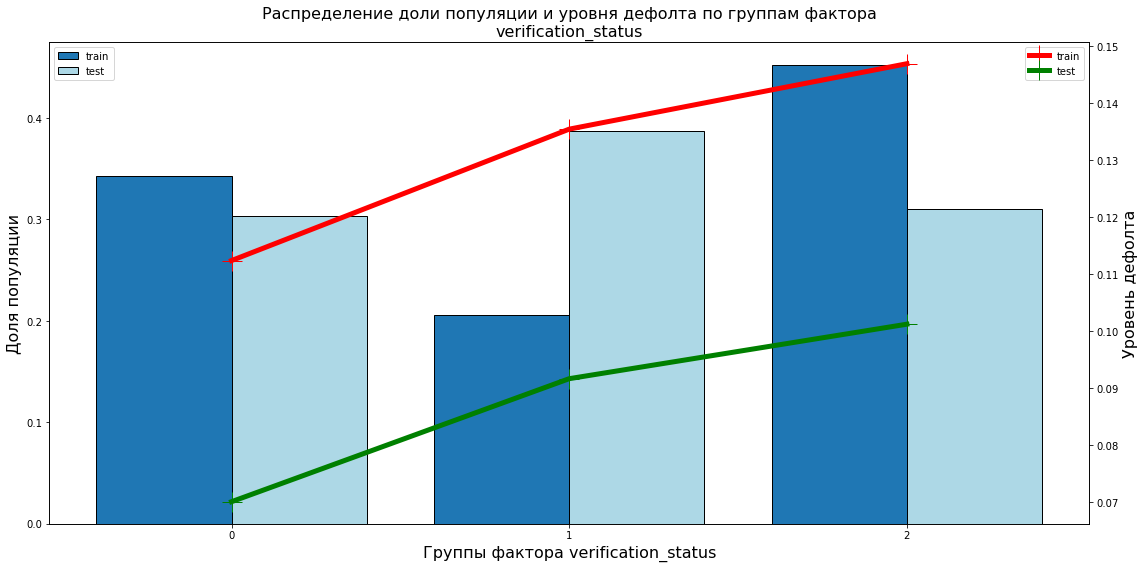

   test_flg GRP_verification_status    cnt  def_cnt  def_rate  pop_rate
0         0                       0  50090     5629     0.112     0.342
2         0                       1  30026     4067     0.135     0.205
4         0                       2  66205     9728     0.147     0.452
1         1                       0  50056     3506     0.070     0.303
3         1                       1  63957     5861     0.092     0.387
5         1                       2  51183     5180     0.101     0.310
Column 14/14
GRP_addr_state


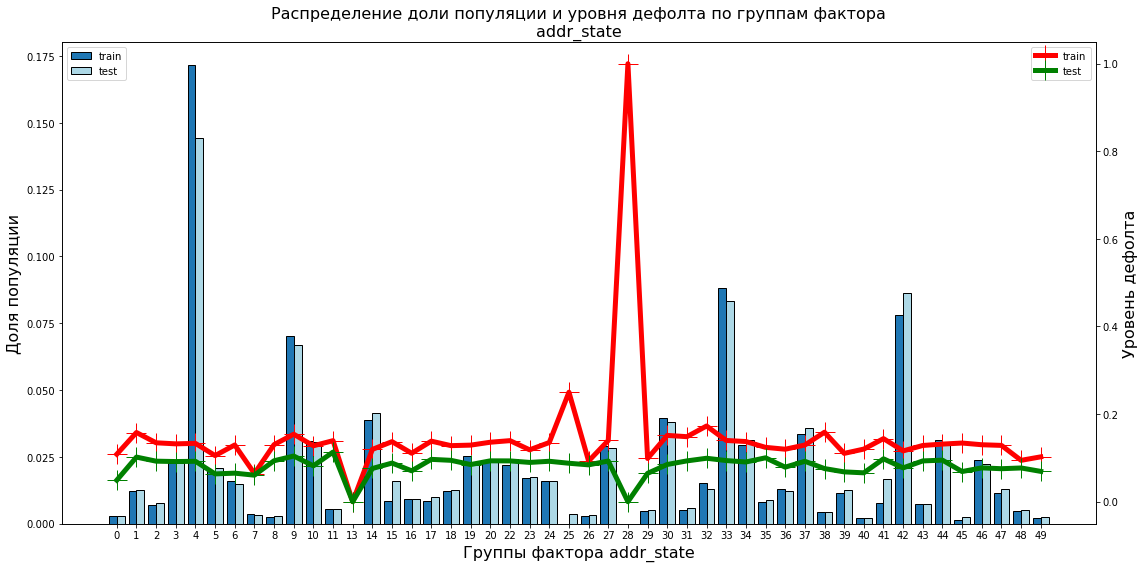

    test_flg GRP_addr_state    cnt  def_cnt  def_rate   pop_rate
0          0              0    443       48     0.108  3.028e-03
3          0              1   1773      280     0.158  1.212e-02
23         0              2   1041      140     0.134  7.114e-03
43         0              3   3324      439     0.132  2.272e-02
65         0              4  25125     3346     0.133  1.717e-01
87         0              5   2907      306     0.105  1.987e-02
89         0              6   2317      300     0.129  1.584e-02
91         0              7    513       33     0.064  3.506e-03
93         0              8    376       49     0.130  2.570e-03
94         0              9  10269     1582     0.154  7.018e-02
5          0             10   4497      574     0.128  3.073e-02
6          0             11    818      114     0.139  5.590e-03
9          0             13      2        0     0.000  1.367e-05
11         0             14   5669      677     0.119  3.874e-02
12         0             

In [36]:
interrval_features_short = [col for col in good_features_short if col in interrval_features]
category_features_short = [col for col in good_features_short if col in category_features]
print_binning(data=data_binned_woe.copy(), 
              interval_attributes=[f'GRP_{col}' for col in interrval_features_short], 
              category_attributes=[f'GRP_{col}' for col in category_features_short], 
              target='target',
              test_flg_name = 'test_flg'
              )

# Task 4. Построение модели логистической регресси на WOE факторах



Пострим модель логисчтической регресси на WOE факторах короткого списка "хороших" атрибутов. 

* Какое получается качество? 
* Чему равен коэффициент Джини на train и test выборках?
* За счет чего можно улучшить качество?
* Проверьте интерпретируемость модели и соответствие атрибутов бизнес смыслу

In [37]:
X_train = data_binned_woe[data_binned_woe['test_flg']==0][['WOE_'+col for col in good_features_short]]
y_train = data_binned_woe[data_binned_woe['test_flg']==0]['target']
X_test = data_binned_woe[data_binned_woe['test_flg']==1][['WOE_'+col for col in good_features_short]]
y_test = data_binned_woe[data_binned_woe['test_flg']==1]['target']

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

pred_train = logreg.predict_proba(X_train)[:, 1]
pred_test = logreg.predict_proba(X_test)[:, 1]

print(f'GINI train: {round(2*roc_auc_score(y_train, pred_train)-1, 4)}')
print(f'GINI test: {round(2*roc_auc_score(y_test, pred_test)-1, 4)}')

GINI train: 0.6786
GINI test: 0.5592


**Ответ:** Ну можно и получше )

Проскорим train и test выборки и сохраним значения вероятностей дефолта

In [38]:
data_binned_woe['PD'] = logreg.predict_proba(data_binned_woe[['WOE_'+col for col in good_features_short]])[:, 1]

# Task 5. Построение скоринговой карты

> Реализуйте функцию построения скоринговой карты.

> При реализации функции учтите следующее:
* 600 - значение на шкале баллов, в которой соотношение шансов составляет С:1
* С = 72
* 40 — количество баллов, удваивающее шансы
* Полученное значение скорингового балла следует округлить до целого

> Описание функции:
* На вход принимает:
1. model - построенная модель логистической регрессии
2. features_short - список атрибутов, на котором построена логистическая регрессия
3. woe_dict_ - словарь со значениями WOE факторов по группам
* Возвращает pandas.DataFrame со следующими полями:
1. ATTRIBUTE - название атрибута
2. GRP - номер ("имя") группы
3. WOE - значение WOE фактора для группы
4. SCORE - величина скорингового балла для данной группы

In [39]:
def build_scorecard(model, features_short, woe_dict_):
    B = 600
    C = 72
    D = 40
    R = D/np.log(2)
    
    bias = model.intercept_[0]
    coef = model.coef_[0]
    A = B - R * np.log(C)
    n = len(coef)
    
    res = pd.DataFrame(columns=['ATTRIBUTE', 'GRP', 'SCORE', 'WOE'])
    
    dfs = []
    for idx, feature in enumerate(features_short):
#         print(coef)
        df = woe_dict_[feature].copy()
        df = df.rename(columns={'GRP_'+feature : 'GRP', 'WOE_'+ feature : 'WOE'})
        df['ATTRIBUTE'] = feature
#         print('WOE', df['WOE'].unique())
        df['SCORE'] = df['WOE'].apply(lambda woe: round(-(woe * coef[idx] + bias/n) * R + A/n) )
        dfs.append(df)
        
    res = pd.concat(dfs)
    return res

In [40]:
# Проверяем реализацию функции
assert_logreg = LogisticRegression(random_state=42).fit(assert_data_binned_woe[[f"WOE_{col}" for col in assert_good_features_short]], assert_data_binned_woe['target'])
assert_scorecard = build_scorecard(model = assert_logreg, 
                                   features_short = assert_good_features_short, 
                                   woe_dict_ = assert_woe_dict
                                   )

assert assert_scorecard.shape == (114, 4)
assert set(assert_scorecard.columns) == {'ATTRIBUTE', 'GRP', 'SCORE', 'WOE'}

# print(round(assert_scorecard['WOE'].sum(), 5))
# print(round(assert_scorecard['SCORE'].sum(), 5))

assert round(assert_scorecard['WOE'].sum(), 5) == 10.47859 #-10.47859 
assert round(assert_scorecard['SCORE'].sum(), 5) == 6510.0

In [41]:
scorecard = build_scorecard(model=logreg, 
                            features_short=good_features_short, 
                            woe_dict_=woe_dict
                            )

In [42]:
pd.set_option('display.max_rows', 100)
scorecard.set_index(['ATTRIBUTE', 'GRP'])

WOE  SCORE
ATTRIBUTE       GRP                                 
last_pymnt_amnt (11856.27, +inf)    -5.410831    344
                (6627.35, 11856.27] -5.315453    338
                (3650.02, 6627.35]  -5.005024    321
                (1333.38, 3650.02]  -2.918373    201
                (688.91, 1333.38]    0.345619     13
...                                       ...    ...
addr_state      40                  -0.114335     39
                45                   0.010206     32
                25                   0.778254     -9
                13                  -0.454942     57
                28                   1.638661    -54

[182 rows x 2 columns]

Присвоим каждому наблюдению скорбалл в зависимости от значения атрибута, а так же финальный скоринговый балл

In [43]:
%%time
data_binned_woe['SCORE'] = 0
for col in scorecard['ATTRIBUTE'].drop_duplicates():
    temp_score = scorecard[scorecard['ATTRIBUTE']==col].copy()
    temp_score = temp_score.rename(columns={'SCORE':'SCORE_'+col, 'GRP':'GRP_'+col})
    data_binned_woe = data_binned_woe.merge(temp_score[['GRP_'+col, 'SCORE_'+col]], on='GRP_'+col, how='left')
    data_binned_woe['SCORE'] = data_binned_woe['SCORE'] + data_binned_woe['SCORE_'+col]

Wall time: 19 s


# Сохранение результатов

Сохраняем обученную модель, короткий список "хороших" атрибутов, проскоренную выборку для дальнейшего использования

In [44]:
%%time
# сохраняем обученную модель
with open('./model_logreg_woe.pickle', 'wb') as f:
    pickle.dump(logreg, f)
    
# сохраняем список атрибутов
with open('./attributes_logreg_woe.pickle', 'wb') as f:
    pickle.dump(good_features_short, f)
    
# сохраняем выборку
data_binned_woe.to_csv('./data_grp_woe_pd_score.csv', index=False)

Wall time: 1min 12s
